In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.downloader.download('vader_lexicon')

<Figure size 432x576 with 0 Axes>

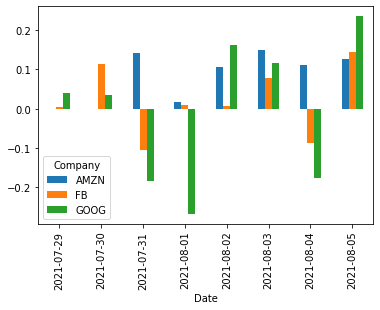

In [24]:
finviz_url = 'https://finviz.com/quote.ashx?t='
Companys = ['AMZN', 'GOOG', 'FB'] # stock companies

news_tables = {} # Declare empty dictionary to store results from finviz

for Company in Companys:
    url = finviz_url + Company
    req = Request(url=url, headers={'user-agent':'my-app'}) # Specify headers or else access will be denied
    response = urlopen(req)
    soup = BeautifulSoup(response,features='html.parser')
    news_table = soup.find(id='news-table')
    # We get table rows
    # We get text on on td tag
    # We get time stamp on tr tag
    news_tables.update({Company:news_table}) # Key ticker (Company name) and value news_table
    

parsed_data = [] # Instantiate new list object

for Company, news_table in news_tables.items(): # This will iterate over all keys and values using the .tems() function
    for row in news_table.find_all('tr'):
        Comments = row.a.text
        date_data = row.td.text.split(' ') # Split date with space 
        # If loop to determine if date is made of 1 or 2 indexes
        if len(date_data)==1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]
        parsed_data.append([Company,date,time,Comments])

    

# print(parsed_data) remember the parsed data is a list of lists

df = pd.DataFrame(parsed_data, columns=['Company','Date','Time','Comments'])
# Analyse your text
vader = SentimentIntensityAnalyzer()
# When we run polarity, we get a couple of key values from the result dictionary
# 'neg', 'neu', 'pos', 'compound'
# We can pull out what ever we want to analyse from this dictionary
# Create a function and get just the compound score
# Then use the apply function to run this function
function = lambda x: vader.polarity_scores(x)['compound']
# We want to loop through our comments column
df['Compound'] = df['Comments'].apply(function)
# Convert date column to date time
df['Date'] = pd.to_datetime(df.Date).dt.date


plt.figure(figsize=(6,8))
# Using groupby makes us to have one date entry
mean_df = df.groupby(['Company','Date']).mean()
# Allow us to have date as x-axis
mean_df = mean_df.unstack()
# Remove compound column
mean_df = mean_df.xs('Compound', axis='columns').transpose()
mean_df.plot(kind='bar')
plt.show()
# print(mean_df)